# The Deep Learning Book (Simplified)
## Part II - Modern Practical Deep Networks
*This is a series of blog posts on the [Deep Learning book](http://deeplearningbook.org)
where we are attempting to provide a summary of each chapter highlighting the concepts 
that we found to be most important so that other people can use it as a starting point
for reading the chapters, while adding further explanations on few areas that we found difficult to grasp. Please refer [this](http://www.deeplearningbook.org/contents/notation.html) for more clarity on 
notation.*


## Chapter 9: Convolutional Networks

**Convolutional networks**, also known as **convolutional neural networks**, or **CNN**s, are a specialized kind of neural network for processing data that has a known grid-like topology. <br>

The chapter is organized as follows:

**1. The Convolution Operation** <br>
**2. Motivation** <br>
**3. Pooling** <br>
**4. Convolution and Pooling as an Infinitely Strong Prior** <br>
**5. Variants of the Basic Convolution Function** <br>
**6. Structured Outputs** <br>
**7. Data Types** <br>
**8. Efficient Convolution Algorithms**<br>
**9. Random and Unsupervised Features**<br>
**10. The Neuroscientific Basis for Convolutional Networks**<br>
**11. Convolutional Networks and the History of Deep Learning**<br>

### 1. The Convolution Operation

- The convolution operates on the **input** with a **kernel** (weights) to produce an **output map** given by:
$$ s(t) = \int x(a)w(t-a)da $$
or in discrete space as:
$$ s(t) = \sum_{a=-\infty}^{\infty} x(a)w(t-a) $$
and in 2D as:
$$ s(i,j) = \sum_m \sum_n x(m,n)w(i-m,j-n) $$
- The flipping of the kernel weights gives the formulation the commutative property, i.e.

$$ s(i,j) = \sum_m \sum_n x(m,n)w(i-m,j-n) = \sum_m \sum_n x(i-m,j-n)w(m,n) $$

- When the kernel isn't flipped, it results in the **cross-correlation** (this operation however lacks the commutative property):

$$ s(i,j) = \sum_m \sum_n x(i+m,j+n)w(m,n) $$

- The operation can be broken into matrix multiplications using the **Toeplitz** matrix representation for 1D and **block-circulant** matrix for 2D convolution

### 2. Motivation

- **Sparse interactions**: Each output unit is connected to (affected by) only a subset of the input units. This significantly reduces the number of parameters and hence the number of computations in the operation. In  *deep CNNs*, the units in the deeper layers interact *indirectly* with large subsets of the input which allows modelling of complex interactions through sparse connections.

- **Parameter sharing**: In a CNN each kernel weight is used at every input position (except maybe at boundaries where different padding rules apply). It can be seen easily that if the same linear operation needs to be applied at all positions in an input image, the convoution representations is much more economical as compared to the equivalent fully-connected variant. Less parameters also implies more statistical efficiency.

* m = number of input units
* n = number of output units
* k = kernel size
* l = number of kernels in the set (for tiled convolution)

| Type | Computations | Parameters |
| --- | --- | --- |
| Fully connected | ***O(mn)*** | ***O(mn)*** |
| Locally connected | ***O(kn)*** | ***O(kn)*** |
| Tiled | ***O(kn)*** | ***O(kl)*** |
| Traditional | ***O(kn)*** | ***O(k)*** |

- **Equivariance**: Parameter sharing also provides **equivariance to translation**
    - A function *f* is said to be equivariant to a function *g* if $f(g(x)) = g(f(x))$ i.e. if input changes, the output changes in the same way
    - Here we see the translation of the image results in corresponding translation in the output map (except maybe for boundary pixels)
    - Note that convolution operation by itself is not equivariant to changes in scale or rotation.

In [1]:
import numpy as np
from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt

# %matplotlib inline

img = misc.ascent()
kernel = np.random.randn(5,5)
# kernel = np.array([[0,-10,0,10,0],[-10,-30,0,30,10],[0,-10,0,10,0]])

img = img.astype(np.float32)/255
orig_in = img

offsetx = offsety = 20
shift_in = np.zeros(orig_in.shape)
shift_in[offsetx:,offsety:] = img[:-offsetx,:-offsety]

rot_in = misc.imrotate(img, 90)
scale_in = misc.imresize(orig_in, 1.5)

output1 = signal.convolve2d(orig_in, kernel, mode='same')
output2 = signal.convolve2d(shift_in, kernel, mode='same')
output3 = signal.convolve2d(rot_in, kernel, mode='same')
output4 = signal.convolve2d(scale_in, kernel, mode='same')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:27: DeprecationWarning: `imrotate` is deprecated!
`imrotate` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.rotate`` instead.
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


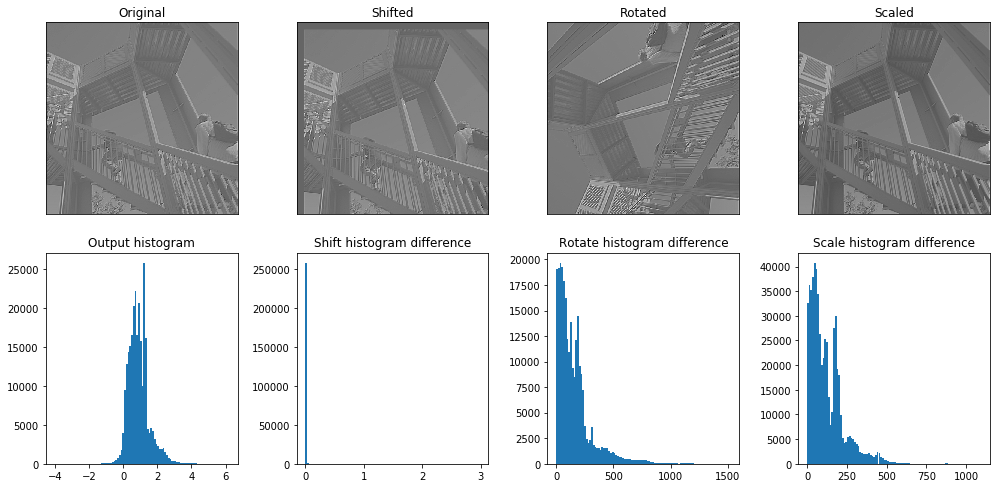

In [6]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))
ax_orig = axes[0,0]
ax_shift = axes[0,1]
ax_rot = axes[0,2]
ax_scale = axes[0,3]

diff_orig = axes[1,0]
diff_shift = axes[1,1]
diff_rot = axes[1,2]
diff_scale = axes[1,3]

ax_orig.imshow(output1, cmap='gray')
ax_orig.set_title('Original')
ax_shift.imshow(output2, cmap='gray')
ax_shift.set_title('Shifted')
ax_rot.imshow(output3, cmap='gray')
ax_rot.set_title('Rotated')
ax_scale.imshow(output4, cmap='gray')
ax_scale.set_title('Scaled')

def shift(arr, offset):
    output = np.zeros(arr.shape)
    output[offset:, offset:] = arr[:-offset,:-offset]
    return output

def rotate(arr, angle):
    return misc.imrotate(arr, angle)

def resize(arr, scale):
    return misc.imresize(arr, scale)

diff_orig.hist(np.ravel(output1),bins=100)
diff_orig.set_title('Output histogram')
diff_shift.hist(np.ravel(np.abs(output2-shift(output1, 20))),bins=100)
diff_shift.set_title('Shift histogram difference')
diff_rot.hist(np.ravel(np.abs(output3-rotate(output1, 10))),bins=100)
diff_rot.set_title('Rotate histogram difference')
diff_scale.hist(np.ravel(np.abs(output4-resize(output1, 1.5))),bins=100)
diff_scale.set_title('Scale histogram difference')

ax_orig.set_xticks([])
ax_shift.set_xticks([])
ax_rot.set_xticks([])
ax_scale.set_xticks([])

ax_orig.set_yticks([])
ax_shift.set_yticks([])
ax_rot.set_yticks([])
ax_scale.set_yticks([])

plt.tight_layout()
# plt.show()
plt.savefig('images/conv_equivariance.png')

### 3. Pooling

A convolutional layer can be broken into the following components:

1. Convolution
2. Activation (detector stage)
3. Pooling


- The pooing function calculates a **summary statistic** of the nearby pixels at the point of operation. Several common statistics are max, mean, weighted average and $L^2$ norm of a surrounding rectangular window.
- Pooling makes the representation slightly **translation invariant** in that small translations in the input do not cause large changes in the output map. It allows detection of a particular feature if we only care about its existence, not its position in an image. This is a strong requirement on the representation learnt.
- Pooling over feature channels can be used to develop invariance to certain transformations of the input. For e.g., units in a layer may be developed to learn rotated features and then pooled over. This property has been used in [maxout networks](http://proceedings.mlr.press/v28/goodfellow13.pdf)
- Pooling reduces the input size to the next layer in turn reducing the number of computations required upstream.
- Variable sized inputs are an issue when presented to a fully connected layer. To counter this, the pooling operation maybe performed on regions of the input (such as quadrants) thus allowing the model to work on variable sized inputs.


[Theoretical guidelines](http://www.di.ens.fr/willow/pdfs/icml2010b.pdf) for which pooling to use have been studied. [Dynamic pooling](http://yann.lecun.com/exdb/publis/pdf/boureau-iccv-11.pdf) has also been studied.

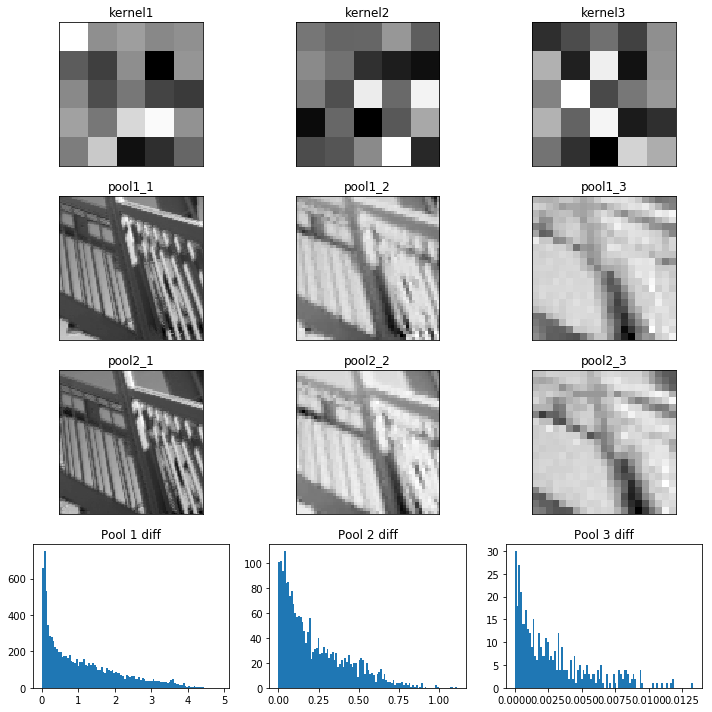

In [11]:
import numpy as np
np.random.seed(101)

from scipy import signal
from scipy import misc
import matplotlib.pyplot as plt
%matplotlib inline

img = misc.ascent()
img = img.astype(np.float32)/255

# The image is more interesting here
orig_in = img[-200:,-300:-100]
offsetx = offsety = 15
shift_in = img[-200-offsetx:-offsetx,-300-offsety:-100-offsety]
kernel1 = np.random.randn(5,5)
kernel2 = np.random.randn(5,5)
kernel3 = np.random.randn(5,5)

def sigmoid(arr):
    # Lazy implementation of sigmoid activation
    return 1./(1 + np.exp(-arr))

def maxpool(arr, poolsize, stride):
    # Lazy looping implementation of maxpool
    output_shape = np.floor((np.array(arr.shape)-poolsize)/stride)+1
    output_shape = output_shape.astype(np.int32)
    output = np.zeros(output_shape)
    for x in range(output_shape[0]):
        for y in range(output_shape[1]):
            output[x,y] = np.max(arr[x*stride:x*stride+poolsize,y*stride:y*stride+poolsize])
    return output

output1_1 = signal.convolve2d(orig_in, kernel1, mode='valid')
pool1_1 = maxpool(output1_1, 2, 2)
actv1_1 = sigmoid(pool1_1)
output1_2 = signal.convolve2d(actv1_1, kernel2, mode='valid')
pool1_2 = maxpool(output1_2, 2, 2)
actv1_2 = sigmoid(pool1_2)
output1_3 = signal.convolve2d(actv1_2, kernel3, mode='valid')
pool1_3 = maxpool(output1_3, 2, 2)

output2_1 = signal.convolve2d(shift_in, kernel1, mode='valid')
pool2_1 = maxpool(output2_1, 2, 2)
actv2_1 = sigmoid(pool2_1)
output2_2 = signal.convolve2d(actv2_1, kernel2, mode='valid')
pool2_2 = maxpool(output2_2, 2, 2)
actv2_2 = sigmoid(pool2_2)
output2_3 = signal.convolve2d(actv2_2, kernel3, mode='valid')
pool2_3 = maxpool(output2_3, 2, 2)

fig, axes = plt.subplots(4, 3, figsize=(10, 10))

k1, k2, k3 = axes[0,:]
p1_1, p1_2, p1_3 = axes[1,:]
p2_1, p2_2, p2_3 = axes[2,:]
h1, h2, h3 = axes[3,:]

k1.imshow(kernel1, cmap='gray')
k1.set_title('kernel1')
k2.imshow(kernel2, cmap='gray')
k2.set_title('kernel2')
k3.imshow(kernel3, cmap='gray')
k3.set_title('kernel3')
k1.set_xticks([])
k2.set_xticks([])
k3.set_xticks([])
k1.set_yticks([])
k2.set_yticks([])
k3.set_yticks([])

p1_1.imshow(pool1_1, cmap='gray')
p1_1.set_title('pool1_1')
p1_2.imshow(pool1_2, cmap='gray')
p1_2.set_title('pool1_2')
p1_3.imshow(pool1_3, cmap='gray')
p1_3.set_title('pool1_3')
p1_1.set_xticks([])
p1_2.set_xticks([])
p1_3.set_xticks([])
p1_1.set_yticks([])
p1_2.set_yticks([])
p1_3.set_yticks([])

p2_1.imshow(pool2_1, cmap='gray')
p2_1.set_title('pool2_1')
p2_2.imshow(pool2_2, cmap='gray')
p2_2.set_title('pool2_2')
p2_3.imshow(pool2_3, cmap='gray')
p2_3.set_title('pool2_3')
p2_1.set_xticks([])
p2_2.set_xticks([])
p2_3.set_xticks([])
p2_1.set_yticks([])
p2_2.set_yticks([])
p2_3.set_yticks([])

h1.hist(np.ravel(np.abs(pool1_1-pool2_1)),bins=100)
h1.set_title('Pool 1 diff')
h2.hist(np.ravel(np.abs(pool1_2-pool2_2)),bins=100)
h2.set_title('Pool 2 diff')
h3.hist(np.ravel(np.abs(pool1_3-pool2_3)),bins=100)
h3.set_title('Pool 3 diff')

plt.tight_layout()
# plt.show()
plt.savefig('images/pool_invariance.png')

### 4. Convolution and Pooling as an Infinitely Strong Prior

**What is a weight prior?** Assumptions about the weights (before learning) in terms of acceptable values and range are encoded into the *prior* distribution of the weights. A *weak prior* is has a high variance and shows that there is low confidence in the initial value of the weight. A *strong prior* is turn shows a narrow range of values about which we are confident before learning begins. An *infinitely strong prior* demarkates certain values as forbidden completely assigning them zero probability.

If we view the convolutional layer as a fully connected layer, **convolution imposes an infinitely strong prior** by making the following restrictions on the weights:
1. Adjacent units must have the same weight but shifted in space
2. Except for a small spatially connected region, all other weights must be zero


Likewise the **pooling stage imposes an infinitely strong prior** by requiring features to be translation invariant.

Insights:
1. Conv and pooling can cause underfitting if the priors imposed are not suitable for the task.
2. Convolutional models should only be compared with other convolutional models. This is because other models which are **permutation invariant** can learn even when input features are permuted (thus loosing spatial relationships). Such models need to learn these spatial relationships (which are hard coded in CNNs). 

### 5. Variants of the Basic Convolution Function

In practical implementations of the convolution operation, certain modifications are made which deviate from the discrete convolution formula mentioned above:

- In general a convolution layer consists of application of several different kernels to the input. This allows the extraction of several different features at all locations in the input
- The input is generally not real-valued but instead vector valued (e.g. RGB values at each pixel or the feature values computed by the previous layer at each pixel position). Multichannel convolutions are commutative only if number of output and input channels is the same.
- In order to allow for calculation of features at a *coarser level* strided convolutions can be used. The effect of strided convolution is the same as that of a convolution followed by a downsampling stage. This can be used to reduce the representation size.
- Zero padding helps to make output dimensions and kernel size independent. 3 common zero padding strategies are:
    1. **valid**: The output is computed only at places where the entire kernel lies inside the input. Essentially, no zero padding is performed. For a kernel of size *k* in any dimension, the input shape of *m* in the direction will become *m-k+1* in the output. This shrinkage restricts architecture depth.
    2. **same**: The input is zero padded such that the spatial size of the input and output is same. Essentially, for a dimension where kernle size is *k*, the input is padded by *k-1* zeros in that dimension. Since the number of output units connected to border pixels is less than that for centre pixels, it may under-represent border pixels.
    3. **full**: The input is padded by enough zeros such that each input pixel is connected to the same number of output units.
    
    In  terms of test set accuracy, the optimal padding is somewhere between *same* and *valid*.
- **Locally connected layer/unshared convolution**: The connectivity graph of convolution operation and locally connected layer is the same. The only difference is that parameter sharing is not performed, i.e. each output unit performs a linear operation on its neighbourhood but the parameters are not shared across output units. This allows models to capture local connectivity while allowing different features to be computed at different spatial locations. This however requires much more parameters than the convolution operation.
- **Tiled convolution** is a sort of middle step between locally connected layer and traditional convolution. It uses a set of kernels that are cycled through. This reduces the number of parameters in the model while allowing for some freedom provided by unshared convolution.
- Another extension can be to restrict the kernels to operate on certain input channels. One way to implement this is to connect the first *m* input channels to the first *n* output channels, the next *m* input channels to the next *n* output channels and so on. This method decreases the number of parameters in the model without dereasing the number of output units.
- **NOTE**: When max pooling operation is applied to locally connected layer or tiled convolution, the model has the ability to become *transformation invariant* because adjacent filters have the freedom to learn a transformed version of the same feature. This essentially similar to the property leveraged by pooling over channels rather than spatially.
- **Bias** terms can be used in different ways in the convolution stage. For locally connected layer and tiled convolution, we can use a bias per output unit and kernel respectively. In case of traditional convolution, a single bias term per output channel is used. If the input size is fixed, a bias per output unit may be used to counter the effect of regional image statistics and smaller activations at the boundary due to zero padding.

#### 5.x Backpropogation through the convolution layer

For a convolutional kernel with kernel stack $K$, multichannel input $V$ and stride $s$, the output $Z$ is given by

\begin{equation} Z_{i,j,k} = c(K,V,s)_{i,j,k} = \sum_{l,m,n} \big[ V_{l,(j-1)\times s+m,(k-1)\times s+n}K_{i,l,m,n} \big] \end{equation}

Suppose we want to minimize loss $J(V,K)$. During back propogation, the layer receives the tensor

\begin{equation} G_{i,j,k} = \frac{\partial}{\partial Z_{i,j,k}}J(V,K) \end{equation}

To compute gradient with respect to kernel parameters, we compute:

\begin{equation} g(G,V,s)_{i,j,k,l} = \frac{\partial}{\partial K_{i,j,k,l}}J(V,K) = \sum_{m,n} G_{i,m,n}V_{j,(m-1)\times s+k, (n-1)\times s+l} \end{equation}

To backpropogate the error to the lower layer, we compute:

\begin{equation} h(K,G,s)_{i,j,k} = \frac{\partial}{\partial V_{i,j,k}}J(V,K) \\
= \sum_{\substack{l,m \\ s.t. \\ (l-1)\times s+m=j}} \sum_{\substack{n,p \\ s.t. \\ (n-1)\times s+p=k}} \sum_{q} K_{q,i,m,p}G_{q,l,n} \end{equation}

### 6. Structured Outputs

Convulutional networks can be trained to output high-dimensional structured output rather than just a classification score. A good example is the task of image segmentation where each pixel needs to be associated with an object class. Here the output is the same size (spatially) as the input. The model outputs a tensor $S$ where $S_{i,j,k}$ is the probability that pixel *(j,k)* belongs to class *i*.

- To produce an output map as the same size as the input map, only **same-padded** convolutions can be stacked.
- Alternatively, a coarser segmentation map can be obtained by allowing the output map to shrink spatially

The output of the first labelling stage can be refined successively by another convolutional model. If the models use tied parameters, this gives rise to a type of **recursive model** as formulated below. The subscript $W$ shows that the weights are shared across the iterations. The $O$ input in the first step is a dummy variable since $Y(0)$ is unavailable.

$$ Y(1) = H_{W}(X, O) $$
$$ Y(2) = H_{W}(X, Y(1)) $$
$$ Y(3) = H_{W}(X, Y(2)) $$
$$ ... $$

The output can be further processed under the assumption that contiguous regions of pixels will tend to belong to the same label. Graphical models can describe this relationship. Alternately, [CNNs can learn to optimize the graphical models training objective](https://www.robots.ox.ac.uk/~vgg/rg/papers/tompson2014.pdf).

### 7. Data Types

> The data used with a convolutional network usually consist of several channels, each channel being the observation of a different quantity at some point in space or time

> One advantage to convolutional networks is that they can also process inputs with varying spatial extents.

When the output is accordingly variable sized, no extra design change needs to be made. If however the output is fixed sized, as in the classification task, a pooling stage with kernel size proportional to the input size needs to be used.

Different data types based on number of spatial dimensions and channels are listed:

| Dimensions | Single channel | Multichannel |
| --- | --- | --- |
| 1D | **Raw audio** (single amplitude value per time point) | **Skeleton animatin data** (orientation of each joint) |
| 2D | **Audio spectrogram** (one FFT coefficient per time point per frequency) | **Color image** (RGB triplet per (x,y) tuple) |
| 3D | **CT scan** (one value per (x,y,z) tuple) | **Color video** (one RGB triplet per (x,y) tuple per time instant) |

### 8. Efficient Convolution Algorithms

In some problem settings, performing convolution as pointwise multiplication in the frequency domain can provide a speed up as compared to direct computation.

When a *d*-dimensional kernel can be broken into the outer product of *d* vectors, the kernel is said to be separable. The corresponding convolution operations are more efficient when implemented as *d* 1-dimensional convolutions rather than a direct *d*-dimensional convolution.

> Devising faster ways of performing convolution or approximate convolution without harming the accuracy of the model is an active area of research

### 9. Random and Unsupervised Features

To reduce the computational cost of training the CNN, we can use features not learned by supervised training.

1. **Random initialization** has been shown to create filters that are [frequency selective and translation invariant](http://www.robotics.stanford.edu/~ang/papers/nipsdlufl10-RandomWeights.pdf). This can be used to inexpesively select the model architecture. Randomly initialize several CNN architectures and just train the last classification layer. Once a winner is determined, that model can be fully trained in a supervised manner.
2. **Hand designed kernels** may be used; e.g. to detect edges at different orientations and intensities
3. **Unsupervised training** of kernels may be performed; e.g. [applying k-means clustering to image patches](https://www-cs.stanford.edu/people/ang/papers/nipsdlufl10-AnalysisSingleLayerUnsupervisedFeatureLearning.pdf) and using the centroids as convolutional kernels. Unsupervised pretraining may offer regularization effect (not well established). It may also allow for training of larger CNNs because of reduced computation cost.

Another approach for CNN training is **greedy layer-wise pretraining** most notably used in [convolutional deep belief network](https://ai.stanford.edu/~ang/papers/icml09-ConvolutionalDeepBeliefNetworks.pdf). As in the case of multi-layer perceptrons, starting with the first, each layer is trained in isolation.

### 10. The Neuroscientific Basis for Convolutional Networks

Hubel and Wiesel studied the activity of neurons in a cat's brain in response to visual stimuli. Their work characterized many aspects of brain function.

In a simplified view, we have:
1. The light entering the eye stimulates the **retina**. The image then passes through the the optic nerve and a region of the brain called the **LGN (lateral geniculate nucleus)**
2. **V1 (primary visual cortex)**: The image produced on the retina is transported to the V1 with minimal processing. The properties of V1 that have been replicated in CNNs are
    - The V1 response is localized spatially, i.e. the upper image stimulates the cells in the upper region of V1 **[kernel]**
    - V1 has simple cells whose activity is a linear function of the input in a small neighbourhood **[convolution]**
    - V1 has complex cells whose activity is invariant to shifts in the position of the feature **[pooling]** as well as some changes in lighting which cannot be captured by spatial pooling **[cross-channel pooling]**
3. There are several stages of V1 like operations.
4. In the *medial temporal lobe*, we find **grandmother cells**. These cells respond to specific concepts and are invariant to several transforms of the input. In the *medial temporal lobe*, researchers also found neurons spiking on a particular concept, e.g. the *Halle Berry neuron* fires when looking at a photo/drawing of *Halle Berry* or even reading the text *Halle Berry*.

The medial temporal neurons are more generic than CNN in that they respond even to specific ideas. A closer match to the function of the last layers of a CNN is the **IT (inferotemporal cortex)**. When viewing an object, information flows from the retina, through LGN, V1, V2, V4 and reaches IT. This happens within 100ms. When a person continues to look at an object, the brain sends top-down feedback signals to affect lower level activation.

Some of the major differences between the human visual system (HVS) and the CNN model are:
- The human eye is low resolution except in a region called **fovea**. Essentially, the eye does not receive the whole image at high resolution but stiches several patches through eye movements called **saccades**. This attention based gazing of the input image is an active research problem. Note: attention mechanisms have been shown to work on natural language tasks.
- Integration of several senses in the HVS while CNNs are only visual
- The HVS processes rich 3D information, and can also determine relations between objects. CNNs for such tasks are in their early stages.
- The feedback from higher levels to V1 has not been incorporated into CNNs with substantial improvement.
- While the  CNN can capture firing rates in the IT, the similarity between intermediate computations is not established. The brain probably uses different activation and pooling functions. Even the linearity of filter response is doubtful as recent models for V1 involve quadratic filters.

Neuroscience tells us very little about the training procedure. Backpropogation which is a standard training mechanism today is not inspired by neuroscience and sometimes considered biologically implausible.

In order to determine the filter parameters used by neurons, a process called **reverse correlation** is used. The neuron activations are measured by an electrode when viewing several white noise images and a linear model is used to approximate this behaviour. It has been shown experimentally that the weights of the fitted model of V1 neurons are described by **Gabor functions**. If we go by the simplified version of the HVS, if the simple cells detect Gabor-like features, then complex cells learn a function of simple cell outputs which is invariant to certain translations and magnitude changes.

A wide variety of statistical learning algorithms (from unsupervised (sparse code) to deep learning (first layer features)) learn features with Gabor-like functions when applied to natural images. This goes to show that while no algorithm can be touted as the *right method* based on Gabor-like feature detectors, a lack of such features may be taken as a *bad sign*.

### 11. Convolutional Networks and the History of Deep Learning

Summarizing a [summary](http://www.deeplearningbook.org/contents/convnets.html#pf28) would be a redundant task.